In [1]:
import numpy as np

import matplotlib.pyplot as plt

import random

import mlrfit as mf
import mfmodel as mfm

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 1000
signal_to_noise = 4


nsamples = 20
L = 5

# ranks = np.array([5, 4, 3, 2, 1])
ranks = np.array([10, 7, 5, 4, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=1000.0
level=1, num_groups=3, mean_size=333.3
level=2, num_groups=7, mean_size=142.9
level=3, num_groups=16, mean_size=62.5
level=4, num_groups=1000, mean_size=1.0


In [5]:
hpart['rows']['lk'][:-1]

[array([   0, 1000]),
 array([   0,  250,  500, 1000]),
 array([   0,  125,  250,  375,  500,  750,  875, 1000]),
 array([   0,   62,  125,  187,  250,  312,  375,  437,  500,  562,  625,
         687,  750,  812,  875,  937, 1000])]

In [6]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=True)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=26.19128797520212, noise_var=6.443397937453874
SNR=4.064825458467909, signal_to_noise=4


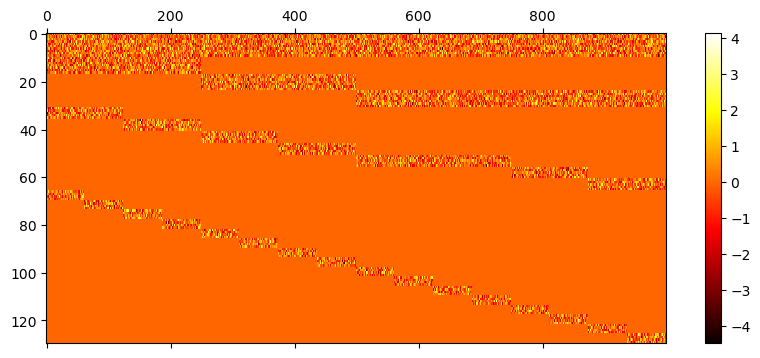

(1000, 130)


In [7]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [8]:
type(true_sparse_F)

numpy.ndarray

In [9]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [10]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  6 15]


In [11]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0
pi = F_hpart['pi']
F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]
v = np.random.randn(n)

# Test matmul

In [12]:
pi = F_hpart['pi']
F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]

In [13]:
ranks1 = ranks + 0
ranks2 = ranks * 2
B1, C1 = np.random.randn(n, ranks1.sum()), np.random.randn(n, ranks1.sum())
B2, C2 = np.random.randn(n, ranks2.sum()), np.random.randn(n, ranks2.sum())

mlr1 = mf.MLRMatrix(B=B1, C=C1, hpart=hpart, ranks=ranks1)
mlr1.construct_sparse_format()

mlr2 = mf.MLRMatrix(B=B2, C=C2, hpart=hpart, ranks=ranks2)
mlr2.construct_sparse_format()

# l1 <= l2
for l2 in range(len(hpart['rows']["lk"])): 
    for l1 in range(l2 + 1):
        lk_1 = hpart['rows']['lk'][l1]
        lk_2 = hpart['rows']['lk'][l2]

        B_l1, C_l1 = B1[:,ranks1[:l1].sum():ranks1[:l1+1].sum()], C1[:,ranks1[:l1].sum():ranks1[:l1+1].sum()]
        B_l2, C_l2 = B2[:,ranks2[:l2].sum():ranks2[:l2+1].sum()], C2[:,ranks2[:l2].sum():ranks2[:l2+1].sum()]

        B = B_l1 + 0
        #  (r_C_l1 x num_blocks_l2 * r_B_l2)
        C_l1t_B_l2 = mfm.mult_blockdiag_refined_CtB(C_l1, hpart['rows']['lk'][l1], 
                                                B_l2, hpart['rows']['lk'][l2])
        true1 = mfm.block_diag_lk(lk_1, C_l1).T @  mfm.block_diag_lk(lk_2, B_l2)
        # indices of groups in B2 that refine groups in C1
        indices_Ct2B = np.searchsorted(lk_2, lk_1, side='left') * B_l2.shape[1] #ranks2[l2]
        assert np.allclose(true1, mfm.block_diag_lk_t(indices_Ct2B, C_l1t_B_l2)) 

        C = mfm.mult_blockdiag_refined_BCt(C_l1t_B_l2, indices_Ct2B, 
                                    C_l2, hpart['rows']['lk'][l2])
        true2 = true1 @ mfm.block_diag_lk(lk_2, C_l2).T
        assert np.allclose(true2.T, mfm.block_diag_lk(lk_1, C)) 

print("PASSED")

PASSED


In [14]:
ranks1 = ranks + 0
ranks2 = ranks * 2
B1, C1 = np.random.randn(n, ranks1.sum()), np.random.randn(n, ranks1.sum())
B2, C2 = np.random.randn(n, ranks2.sum()), np.random.randn(n, ranks2.sum())

mlr1 = mf.MLRMatrix(B=B1, C=C1, hpart=hpart, ranks=ranks1)
mlr1.construct_sparse_format()

mlr2 = mf.MLRMatrix(B=B2, C=C2, hpart=hpart, ranks=ranks2)
mlr2.construct_sparse_format()

# l1 <= l2
for l2 in range(len(hpart['rows']["lk"])): 
    for l1 in range(len(hpart['rows']["lk"])):
        lk_1 = hpart['rows']['lk'][l1]
        lk_2 = hpart['rows']['lk'][l2]

        B_l1, C_l1 = B1[:,ranks1[:l1].sum():ranks1[:l1+1].sum()], C1[:,ranks1[:l1].sum():ranks1[:l1+1].sum()]
        B_l2, C_l2 = B2[:,ranks2[:l2].sum():ranks2[:l2+1].sum()], C2[:,ranks2[:l2].sum():ranks2[:l2+1].sum()]

        B, C = mfm.mlr_level_matvec(l1, B_l1, C_l1, l2, B_l2, C_l2, hpart["rows"])

        if l1 <= l2:
            true1 = mfm.block_diag_lk(lk_1, C_l1).T @  mfm.block_diag_lk(lk_2, B_l2)
            true_C = true1 @ mfm.block_diag_lk(lk_2, C_l2).T
            assert np.allclose(true_C.T, mfm.block_diag_lk(lk_1, C))
        else:
            true1 = mfm.block_diag_lk(lk_1, C_l1).T @  mfm.block_diag_lk(lk_2, B_l2)
            true_B = mfm.block_diag_lk(lk_1, B_l1) @ true1
            assert np.allclose(true_B, mfm.block_diag_lk(lk_2, B))

print("PASSED")

PASSED


## Sum of MLR is MLR with concatenated factors

In [15]:
ranks1 = ranks + 0
ranks2 = ranks * 2

for t in range(10):
    B1, C1 = np.random.randn(n, ranks1.sum()), np.random.randn(n, ranks1.sum())
    B2, C2 = np.random.randn(n, ranks2.sum()), np.random.randn(n, ranks2.sum())

    mlr1 = mf.MLRMatrix(B=B1, C=C1, hpart=hpart, ranks=ranks1)
    mlr1.construct_sparse_format()

    mlr2 = mf.MLRMatrix(B=B2, C=C2, hpart=hpart, ranks=ranks2)
    mlr2.construct_sparse_format()

    B, C, ranks = mfm.mlr_mlr_sum(B1, C1, ranks1, B2, C2, ranks2, hpart["rows"])

    true_AA_p = mlr1.matrix() + mlr2.matrix()
    mlr_sum = mf.MLRMatrix(B=B, C=C, hpart=hpart, ranks=ranks)

    assert np.allclose(true_AA_p, mlr_sum.matrix()), print(t, mf.rel_diff(true_AA_p, mlr_sum.matrix()))


print("PASSED")

PASSED


In [16]:
ranks1 = ranks + 0
ranks2 = ranks * 2
B1, C1 = np.random.randn(n, ranks1.sum()), np.random.randn(n, ranks1.sum())
B2, C2 = np.random.randn(n, ranks2.sum()), np.random.randn(n, ranks2.sum())

mlr1 = mf.MLRMatrix(B=B1, C=C1, hpart=hpart, ranks=ranks1)
mlr1.construct_sparse_format()

mlr2 = mf.MLRMatrix(B=B2, C=C2, hpart=hpart, ranks=ranks2)
mlr2.construct_sparse_format()


for l in range(len(hpart['rows']["lk"])): 
    lk = hpart['rows']['lk'][l]

    B_l1, C_l1 = B1[:,ranks1[:l].sum():ranks1[:l+1].sum()], C1[:,ranks1[:l].sum():ranks1[:l+1].sum()]
    B_l2, C_l2 = B2[:,ranks2[:l].sum():ranks2[:l+1].sum()], C2[:,ranks2[:l].sum():ranks2[:l+1].sum()]

    B = np.concatenate([B_l1, B_l2], axis=1)
    C = np.concatenate([C_l1, C_l2], axis=1)
    true_A1l_A2l = mfm.block_diag_lk(lk, B_l1) @  mfm.block_diag_lk(lk, C_l1).T + \
                    mfm.block_diag_lk(lk, B_l2) @  mfm.block_diag_lk(lk, C_l2).T
    assert np.allclose(true_A1l_A2l, mfm.block_diag_lk(lk, B) @ mfm.block_diag_lk(lk, C).T)


print("PASSED")

PASSED


## Matrix multiplication MLR with MLR is MLR

In [17]:
for _ in range(10):
    B1, C1 = np.random.randn(n, ranks1.sum()), np.random.randn(n, ranks1.sum())
    B2, C2 = np.random.randn(n, ranks2.sum()), np.random.randn(n, ranks2.sum())

    mlr1 = mf.MLRMatrix(B=B1, C=C1, hpart=hpart, ranks=ranks1)
    mlr1.construct_sparse_format()

    mlr2 = mf.MLRMatrix(B=B2, C=C2, hpart=hpart, ranks=ranks2)
    mlr2.construct_sparse_format()
    
    B, C, ranks = mfm.mlr_mlr_matmul(B1, C1, ranks1, B2, C2, ranks2, hpart["rows"])

    true_AA_p = mlr1.matrix() @ mlr2.matrix()
    mlr_prod = mf.MLRMatrix(B=B, C=C, hpart=hpart, ranks=ranks)

    assert np.allclose(true_AA_p, mlr_prod.matrix())


print("PASSED")

PASSED
